# Weather - Time Series Forecasting 
### This notebook uses a Ridge regression model to predict high and low temperatures using data from May 2023 to July 2024 of 9 major cities.

## Import Libraries and Data

In [271]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import Ridge
from statsmodels.tsa.stattools import adfuller
import numpy as np
import seaborn as sns
import joblib
import statsmodels.stats.api as sms
from scipy.stats import shapiro, probplot
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan


# Define seaborn color palette for plots
color_pal = sns.color_palette()

# Read the CSV file into Pandas DataFrame and set index to datatime column
df = pd.read_csv("Weather_data_2023_2024.csv", parse_dates=True, index_col="datetime")

## Data Exploration
### Understanding characteristics and patterns, identify any potential issues, and set the foundation for building accurate forecasting models. 

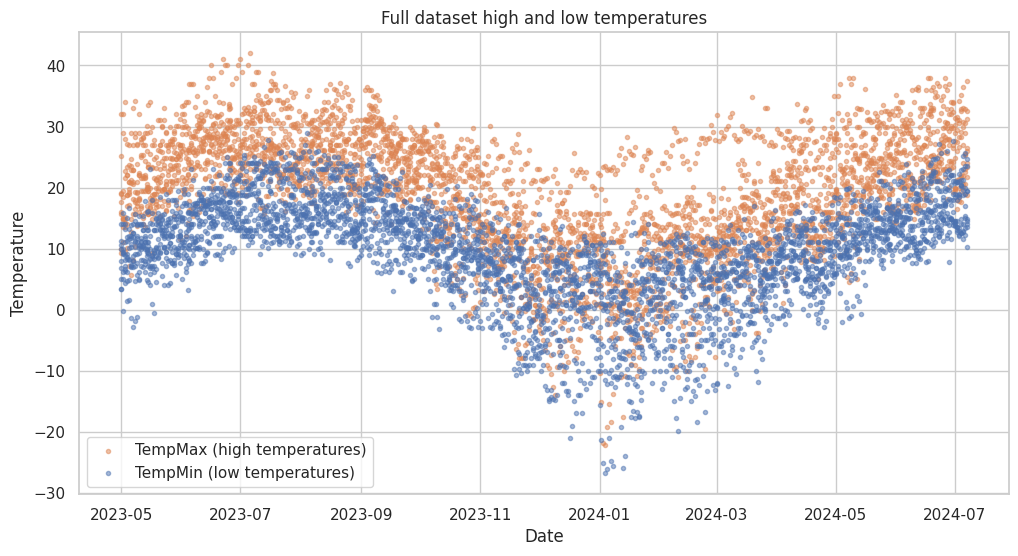

In [272]:
# Plot tempmax and tempmin (target variables) to get an idea of the distribution
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(df.index, df['tempmax'], color=color_pal[1], label='TempMax (high temperatures)', alpha=0.5, marker='.')
plt.scatter(df.index, df['tempmin'], color=color_pal[0], label='TempMin (low temperatures)', alpha=0.5, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [273]:
# Display first rows
df.head()

,location,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,sealevelpressure,cloudcover,visibility,sunrise,sunset,moonphase,conditions,description,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,
2023-05-01,Beijing,25.2,8.0,18.1,25.2,8.0,18.1,8.1,54.7,0.0,...,1009.6,54.2,10.4,2023-05-01T05:15:37,2023-05-01T19:08:22,0.35,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"ZBAA,54511099999"
2023-05-02,Beijing,29.0,15.8,22.3,27.9,15.8,22.1,10.4,48.9,0.0,...,1008.3,26.0,10.6,2023-05-02T05:14:22,2023-05-02T19:09:22,0.39,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"ZBAA,54511099999"
2023-05-03,Beijing,28.0,14.0,21.2,27.6,14.0,21.1,12.4,59.4,0.0,...,1011.3,62.2,10.1,2023-05-03T05:13:08,2023-05-03T19:10:22,0.42,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"ZBAA,54511099999"
2023-05-04,Beijing,22.0,15.0,17.8,22.0,15.0,17.8,14.0,79.1,0.1,...,1009.2,85.1,8.4,2023-05-04T05:11:56,2023-05-04T19:11:22,0.45,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"ZBAA,54511099999"
2023-05-05,Beijing,19.0,16.7,17.8,19.0,16.7,17.8,9.5,61.9,1.1,...,1009.1,95.8,11.4,2023-05-05T05:10:45,2023-05-05T19:12:22,0.48,"Rain, Overcast",Cloudy skies throughout the day with rain clea...,rain,"ZBAA,54511099999"


In [274]:
# Check for duplicate values in data
df.duplicated().sum()

0

In [275]:
# Display missing values
df.isnull().sum()

location             0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            53
dtype: int64

In [276]:
# Drop Columns of no interest
df = df.drop(columns=['stations', 'icon', 'description', 'conditions', 'sunset', 'sunrise'])

# Display updated dataframe
df.head()

,location,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase
datetime,,,,,,,,,,,,,,,,,,,,,
2023-05-01,Beijing,25.2,8.0,18.1,25.2,8.0,18.1,8.1,54.7,0.0,...,0.00,0.0,0.0,36.4,21.6,110.5,1009.6,54.2,10.4,0.35
2023-05-02,Beijing,29.0,15.8,22.3,27.9,15.8,22.1,10.4,48.9,0.0,...,0.00,0.0,0.0,37.4,21.6,133.7,1008.3,26.0,10.6,0.39
2023-05-03,Beijing,28.0,14.0,21.2,27.6,14.0,21.1,12.4,59.4,0.0,...,0.00,0.0,0.0,30.6,18.0,122.7,1011.3,62.2,10.1,0.42
2023-05-04,Beijing,22.0,15.0,17.8,22.0,15.0,17.8,14.0,79.1,0.1,...,4.17,0.0,0.0,28.8,14.4,99.7,1009.2,85.1,8.4,0.45
2023-05-05,Beijing,19.0,16.7,17.8,19.0,16.7,17.8,9.5,61.9,1.1,...,8.33,0.0,0.0,46.8,28.8,5.6,1009.1,95.8,11.4,0.48


### Feature preparation/exploration before feature engineering

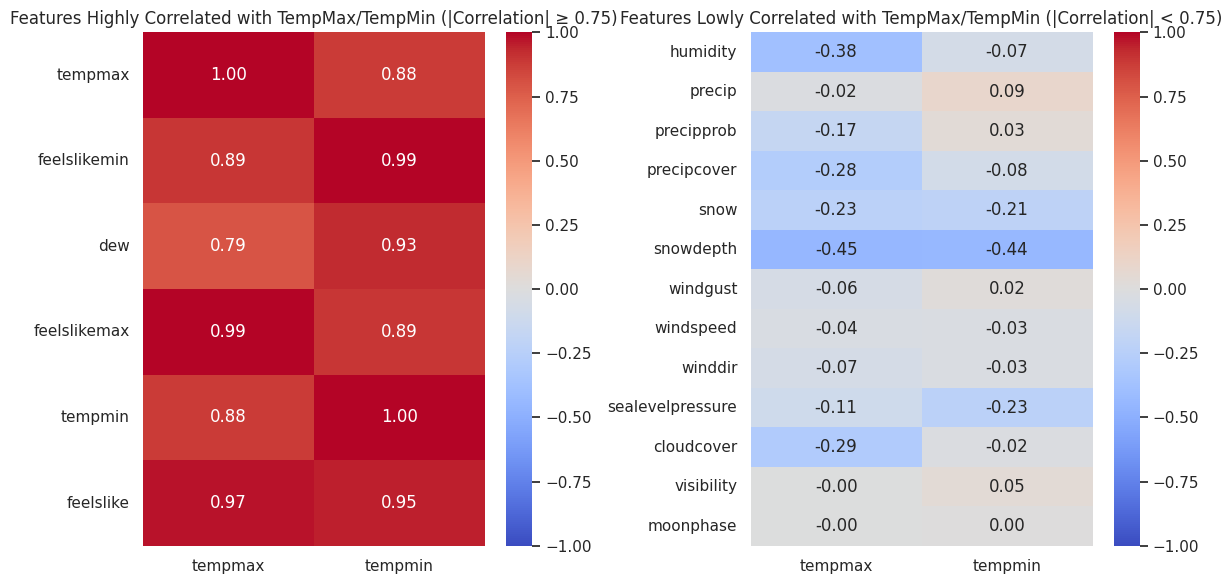

In [277]:
# Select numerical features that might indicate multicollinearity
all_features = df[['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip',
                   'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
                   'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']]

# Compute the correlation matrix
correlation_matrix = all_features.corr()

# Set the threshold for high and low correlation
threshold = 0.75

# Filter for features above the threshold (correlation with target variables)
high_corr_max = correlation_matrix.loc['tempmax'][(correlation_matrix.loc['tempmax'] >= threshold) | (correlation_matrix.loc['tempmax'] <= -threshold)]
high_corr_min = correlation_matrix.loc['tempmin'][(correlation_matrix.loc['tempmin'] >= threshold) | (correlation_matrix.loc['tempmin'] <= -threshold)]

# Combine the above-threshold features
high_corr_features = list(set(high_corr_max.index.tolist() + high_corr_min.index.tolist()))

# Create a new correlation matrix for high correlation features
high_correlation_matrix = correlation_matrix.loc[high_corr_features, ['tempmax', 'tempmin']]

# Create a new correlation matrix for low correlation features (excluding those above the threshold)
low_correlation_matrix = correlation_matrix.drop(high_corr_features).loc[:, ['tempmax', 'tempmin']]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the heatmap for features with high correlations against the target variables
sns.heatmap(high_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("Features Highly Correlated with TempMax/TempMin (|Correlation| ≥ 0.75)")

# Plot the heatmap for features with low correlations against the target variables
sns.heatmap(low_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title("Features Lowly Correlated with TempMax/TempMin (|Correlation| < 0.75)")

# Adjust the layout
plt.tight_layout()
plt.show()


### Analyzing the central tendency, symmetry, and variability of dataset
- **Variability**: Features with high variability (e.g., TempMax, TempMin, Dew, Humidity, FeelsLike) provide a wide range of values, which can enhance the model's ability to capture patterns and make accurate predictions.
- **Distribution Symmetry**: When the mean and median of a feature are close, it suggests a relatively normal distribution, which is generally favorable for many models.
- **Standard Deviation**: A high standard deviation indicates that the data points are spread out over a wide range, which can provide valuable insights for model performance.

In [278]:
# Display summary statistics
display(df.describe())

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase
count,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000
mean,18.955402,9.414849,14.202330,18.499795,8.157168,13.398541,7.346467,67.568152,1.929340,48.888121,10.350663,0.087839,1.556759,35.276165,21.005428,191.912801,1014.354916,58.267588,16.540374,0.487063
std,9.830447,8.251788,8.749541,10.906910,9.876715,10.188162,8.307355,15.369026,5.591233,49.747341,16.836617,0.816638,7.414970,13.533089,7.653159,100.153515,8.854499,27.783827,8.760752,0.288540
min,-22.100000,-26.800000,-24.900000,-30.900000,-35.400000,-33.100000,-27.900000,10.100000,0.000000,0.000000,0.000000,0.000000,0.000000,5.400000,4.300000,0.000000,966.700000,0.000000,2.600000,0.000000
25%,12.500000,5.100000,9.200000,12.500000,3.000000,7.900000,3.225000,58.100000,0.000000,0.000000,0.000000,0.000000,0.000000,25.900000,15.900000,112.900000,1009.600000,38.000000,10.000000,0.250000
50%,20.600000,10.500000,15.800000,20.600000,10.500000,15.800000,8.800000,69.600000,0.000000,0.000000,0.000000,0.000000,0.000000,34.200000,20.100000,203.400000,1014.800000,61.850000,14.100000,0.500000
75%,26.400000,15.000000,20.200000,26.300000,15.000000,20.200000,13.000000,79.100000,1.059000,100.000000,12.500000,0.000000,0.000000,43.200000,24.900000,271.700000,1019.575000,81.900000,21.200000,0.750000
max,42.000000,28.900000,33.000000,46.000000,36.700000,40.800000,27.700000,99.500000,134.000000,100.000000,100.000000,24.800000,62.200000,175.700000,178.500000,359.900000,1044.300000,100.000000,49.600000,0.980000


### Findings:
- Our data has no duplicate values which is a good sign and ensures data integrity.
- The missing values are in a column that we can drop due to its lack of importance for our goal, ensuring no unnecessary noise is introduced into the model.
- The data exhibits highly correlated features, particularly among temperature and feels-like metrics, which we should address moving forward by either removing or combining these features to reduce multicollinearity.
- The summary statistics reveal a mix of normally distributed and skewed data, with some features like precipitation, snow, and snow depth being sporadic but significant when they occur. This indicates that special handling might be needed for these features, such as transformation or imputation.
- The variability in wind direction and pressure suggests these features are quite dynamic, which could be crucial for model accuracy in predicting weather conditions.
### Actions:
- Drop the column with missing values to streamline the dataset and focus on more relevant features.
- Conduct further analysis to address multicollinearity by removing or combining highly correlated features, which will help improve model performance and interpretability.
- Consider data transformations for skewed features like precipitation and snow to normalize their distributions and enhance model performance.
- Evaluate the need for feature engineering on dynamic features like wind direction and sealevel pressure, possibly through binning or interaction terms, to capture their impact more effectively in the model.
- Prepare the data for modeling by finalizing feature selection and ensuring that all features contribute meaningfully to the prediction task.

## Feature Selection and Engineering

In [279]:
# Drop target variables
all_features = all_features.drop(['tempmax', 'tempmin'], axis=1)

# Calculate VIF for each feature in tempmax
vif_data = pd.DataFrame()
vif_data["all initial features"] = all_features.columns
vif_data["VIF"] = [variance_inflation_factor(all_features.values, i) for i in range(all_features.shape[1])]

vif_data

,all initial features,VIF
0,feelslikemax,252.954949
1,feelslikemin,73.212278
2,feelslike,512.314310
3,dew,125.018260
4,humidity,357.713279
5,precip,1.578707
6,precipprob,3.837234
7,precipcover,3.380402
8,snow,1.187286
9,snowdepth,1.482063


In [280]:
# Combine features of significant importance for multicollinearity and redefine dataframe (feature importance results in the section below)
df['feelslike_max_combined'] = df[['feelslikemax', 'feelslike']].mean(axis=1)
df['feelslike_min_combined'] = df[['feelslikemin', 'feelslike']].mean(axis=1)
df['dew_humidity'] = df[['dew', 'humidity']].mean(axis=1)

combined_features = df[['feelslike_max_combined', 'feelslike_min_combined', 'dew_humidity']]
combined_features

,feelslike_max_combined,feelslike_min_combined,dew_humidity
datetime,,,
2023-05-01,21.65,13.05,31.40
2023-05-02,25.00,18.95,29.65
2023-05-03,24.35,17.55,35.90
2023-05-04,19.90,16.40,46.55
2023-05-05,18.40,17.25,35.70
...,...,...,...
2024-07-03,27.55,21.90,38.05
2024-07-04,32.50,24.95,45.15
2024-07-05,36.10,28.75,51.20


### Addressing Autocorrelation in Feature Engineering
During model training and evaluation, significant autocorrelations in the residuals were observed, as indicated by the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots, as well as the Durbin-Watson test.

To address this and better capture temporal patterns in the data, lagged variables for key features were introduced. These lagged variables help in modeling the time dependencies and improving the model’s performance.

In [281]:
# Function to create lagged variables
def create_lagged_variables(df, columns, lags):
    for col in columns:
        for lag in lags:
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

# Function to interpolate lagged variables
def interpolate_columns(df, columns):
    df[columns] = df[columns].interpolate()
    return df

# Define columns and lags
tempmax_columns = ['feelslike_max_combined']
tempmin_columns = ['dew_humidity', 'snow']
short_lags = [1]
all_lags = [1, 4, 7, 19]

# Create lagged variables
df = create_lagged_variables(df, tempmax_columns, short_lags)
df = create_lagged_variables(df, tempmin_columns, all_lags)

# Interpolate lagged variables
lagged_columns = [f'{col}_lag{lag}' for col in tempmax_columns for lag in short_lags] + \
                 [f'{col}_lag{lag}' for col in tempmin_columns for lag in all_lags]
df = interpolate_columns(df, lagged_columns)

# Drop any remaining null values in df
df = df.dropna()

# Combine most important lagged values by taking the mean
df['feelslike_max_combined_lags'] = df[['feelslike_max_combined', 'feelslike_max_combined_lag1']].mean(axis=1)
df['dew_humidity_lags'] = df[[f'dew_humidity_lag{lag}' for lag in all_lags]].mean(axis=1)
df['snow_lags'] = df[['snow', 'snow_lag1']].mean(axis=1)

# Recalculate the features DataFrame with lagged variables for tempmax
features_combined_max = df[['feelslike_max_combined_lags', 'dew_humidity', 'snow', 'windgust']]

# Recalculate the features DataFrame with lagged variables for tempmin
features_combined_min = df[['feelslike_min_combined', 'dew_humidity_lags', 'snow_lags', 'precipcover']]


In [282]:
display(features_combined_max)
display(features_combined_min)

,feelslike_max_combined_lags,dew_humidity,snow,windgust
datetime,,,,
2023-05-20,20.300,11.15,0.0,56.5
2023-05-21,23.450,13.50,0.0,46.8
2023-05-22,24.775,19.65,0.0,33.8
2023-05-23,25.450,21.45,0.0,34.6
2023-05-24,25.900,25.45,0.0,54.0
...,...,...,...,...
2024-07-03,27.100,38.05,0.0,24.1
2024-07-04,30.025,45.15,0.0,18.4
2024-07-05,34.300,51.20,0.0,11.9


,feelslike_min_combined,dew_humidity_lags,snow_lags,precipcover
datetime,,,,
2023-05-20,17.95,38.4250,0.0,0.00
2023-05-21,20.50,28.2750,0.0,0.00
2023-05-22,17.85,29.3000,0.0,0.00
2023-05-23,17.35,39.5375,0.0,0.00
2023-05-24,21.50,26.4750,0.0,0.00
...,...,...,...,...
2024-07-03,21.90,38.3625,0.0,0.00
2024-07-04,24.95,39.4625,0.0,12.50
2024-07-05,28.75,34.8875,0.0,12.50


In [283]:
# Define target variables
y_max = df['tempmax']
y_min = df['tempmin']

# Initialize empty list to store features
X_max = features_combined_max.columns.tolist()
X_min = features_combined_min.columns.tolist()


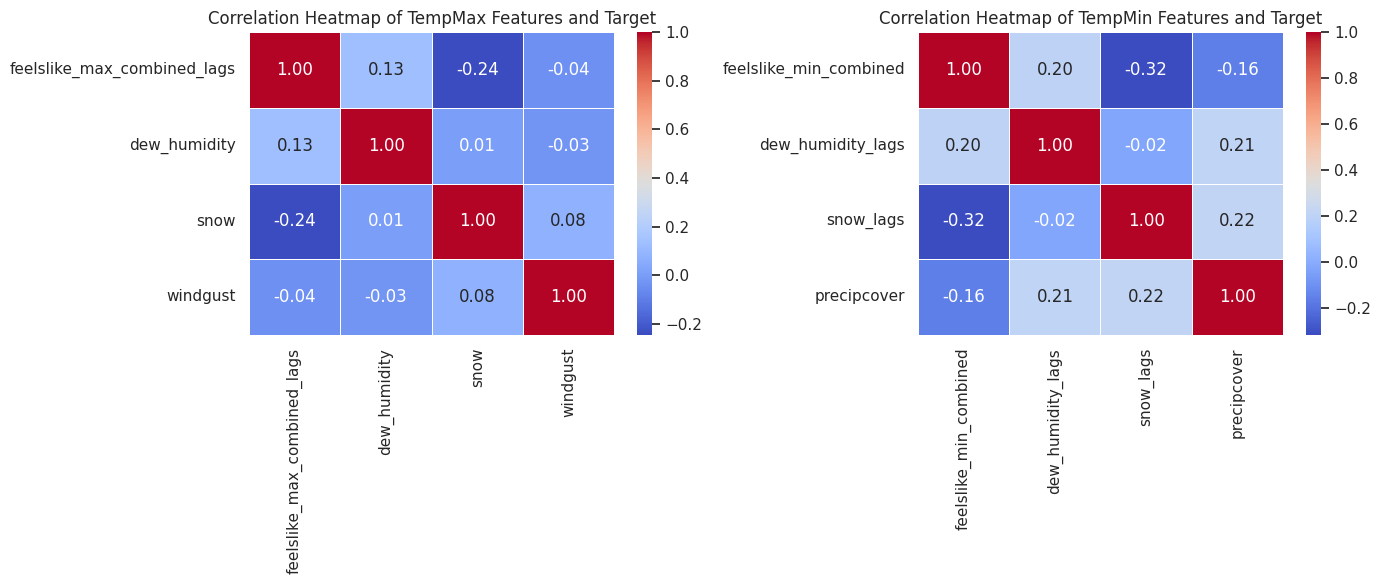

In [284]:
# Get correlation of tempmax and tempmin features
matrix_max = features_combined_max.corr()
matrix_min = features_combined_min.corr()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot heatmap for TempMax
sns.heatmap(matrix_max, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Heatmap of TempMax Features and Target')

# Plot heatmap for TempMin
sns.heatmap(matrix_min, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[1])
axes[1].set_title('Correlation Heatmap of TempMin Features and Target')

plt.tight_layout()
plt.show()

### Addressing Multicollinearity with Variance Inflation Factor
- VIF > 10 indicates significant multicollinearity, which can negatively impact the performance and interpretability of the model. Steps to address it can include removing or combining the highly correlated features.
- slightly higher VIFs (e.g., up to 15) may still be acceptable, especially if the features are critical to the model’s predictive power.

In [285]:
# Calculate VIF for each feature in tempmax
vif_data_max = pd.DataFrame()
vif_data_max["tempmax feature"] = features_combined_max.columns
vif_data_max["VIF"] = [variance_inflation_factor(features_combined_max.values, i) for i in range(features_combined_max.shape[1])]

# Calculate VIF for each feature in tempmin
vif_data_min = pd.DataFrame()
vif_data_min["tempmin feature"] = features_combined_min.columns
vif_data_min["VIF"] = [variance_inflation_factor(features_combined_min.values, i) for i in range(features_combined_min.shape[1])]

,tempmax feature,VIF
0,feelslike_max_combined_lags,3.444812
1,dew_humidity,7.068308
2,snow,1.082608
3,windgust,5.488185


,tempmin feature,VIF
0,feelslike_min_combined,2.566945
1,dew_humidity_lags,3.231614
2,snow_lags,1.162367
3,precipcover,1.542622


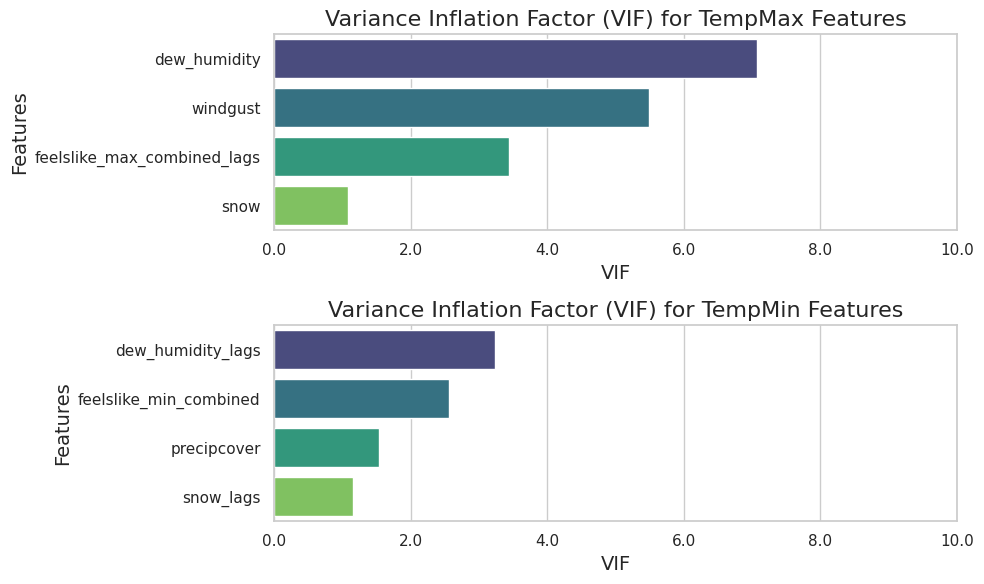

In [286]:
# Display vif dataframe to see exact numbers
display(vif_data_max)
display(vif_data_min)

# Plotting the VIF results for tempmax and tempmin as subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
sns.set(style="whitegrid")

# VIF for TempMax Features
sns.barplot(x="VIF", y="tempmax feature", hue="tempmax feature", dodge=False, data=vif_data_max.sort_values(by="VIF", ascending=False), palette="viridis", ax=axes[0], legend=False)
axes[0].set_title('Variance Inflation Factor (VIF) for TempMax Features', fontsize=16)
axes[0].set_xlabel('VIF', fontsize=14)
axes[0].set_ylabel('Features', fontsize=14)
axes[0].set_xlim(0, 10)
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# VIF for TempMin Features
sns.barplot(x="VIF", y="tempmin feature", hue="tempmin feature", dodge=False, data=vif_data_min.sort_values(by="VIF", ascending=False), palette="viridis", ax=axes[1], legend=False)
axes[1].set_title('Variance Inflation Factor (VIF) for TempMin Features', fontsize=16)
axes[1].set_xlabel('VIF', fontsize=14)
axes[1].set_ylabel('Features', fontsize=14)
axes[1].set_xlim(0, 10)
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# Adjust layout
plt.tight_layout()
plt.show()

### Findings:
**High Multicollinearity**:
Initial VIF analysis revealed significant multicollinearity among the original features, particularly in temperature-related features (feelslike, feelslikemax, feelslikemin), dew point (dew), and humidity.

**Example VIF scores**:
- feelslike: 512.31
- feelslikemax: 252.95
- dew: 125.02
- humidity: 357.71

### Actions Taken:
**Feature Combination**: To reduce multicollinearity, highly correlated features were combined:
- **feelslike_max_combined**: Average of feelslikemax and feelslike.
- **feelslike_min_combined**: Average of feelslikemin and feelslike.
- **dew_humidity**: Average of dew and humidity.

**Creation of Lagged Variables**: Lagged variables were introduced for key features to capture temporal patterns and address autocorrelation (discovered during model training and evaluation):
- **feelslike_max_combined_lags**: Lagged values of feelslike_max_combined.
- **dew_humidity_lags**: Lagged values of dew_humidity.
- **snow_lags**: Lagged values of snow.

**Reevaluation of VIF After Feature Engineering**: VIF recalculated for the new feature sets showed reduced multicollinearity, indicating improved feature set stability.

## Data Splitting - Train/Validate/Test
Splitting time series data before training is essential to maintain the temporal sequence, prevent data leakage, and ensure an unbiased evaluation of the model's performance. This approach enables the model to generalize better and reflect real-world scenarios.

For this project, we’ve divided the data as follows:
- **Training Set (~70%)**: Used to fit the model, where it learns patterns, relationships, and trends to form the foundation of its predictions.
- **Validation Set (~10%)**: Used to fine-tune the model by assessing performance after initial training, aiding in model selection, feature selection, and hyperparameter tuning.
- **Test Set (~20%)**: Used to evaluate the final model’s performance, providing an unbiased assessment of how it will perform on unseen data.

In [287]:
# Define split dates
train_end_date = pd.to_datetime('2024-03-01')
validate_end_date = pd.to_datetime('2024-04-13')
test_start_date = pd.to_datetime('2024-04-13')

In [288]:
# Split the data into training, validation, and testing sets
train = df.loc[df.index < train_end_date]
validate = df.loc[(df.index >= train_end_date) & (df.index < validate_end_date)]
test = df.loc[df.index >= test_start_date]

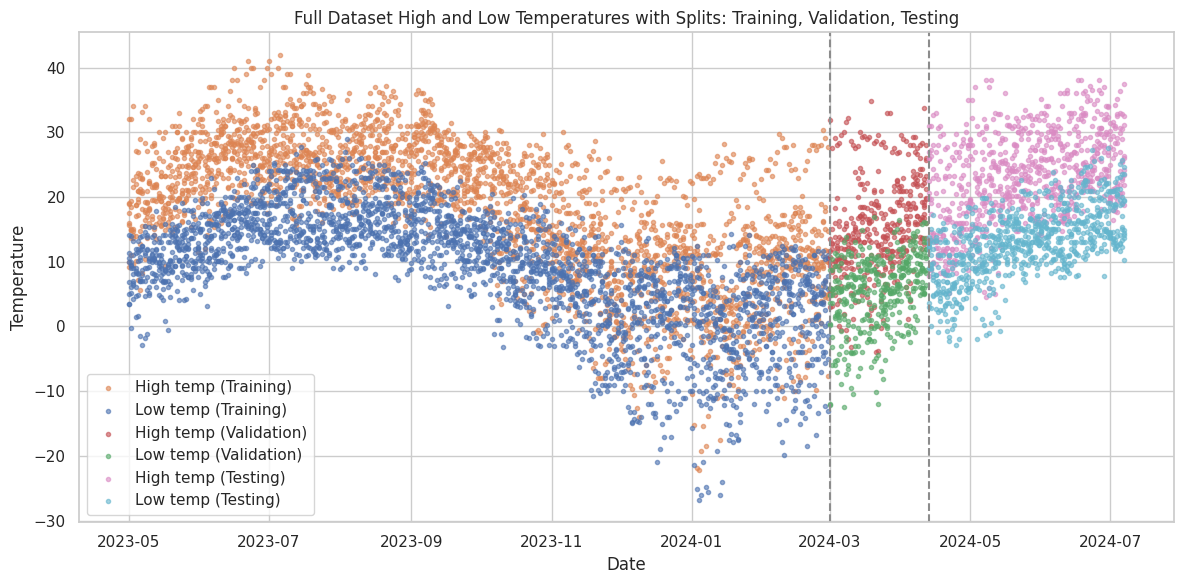

In [289]:
# Create scatter plots to visualize splits
fig, ax = plt.subplots(figsize=(12, 6))

# Plot temperatures for each dataset: train, validate, test
for dataset, color, label_max, label_min in zip([train, validate, test],
                                                [(color_pal[1], color_pal[0]),
                                                 (color_pal[3], color_pal[2]),
                                                 (color_pal[6], color_pal[9])],
                                                ['High temp (Training)', 'High temp (Validation)', 'High temp (Testing)'],
                                                ['Low temp (Training)', 'Low temp (Validation)', 'Low temp (Testing)']):
    plt.scatter(dataset.index, dataset['tempmax'], color=color[0], label=label_max, alpha=0.6, marker='.')
    plt.scatter(dataset.index, dataset['tempmin'], color=color[1], label=label_min, alpha=0.6, marker='.')

# Add vertical lines to mark the splits
ax.axvline(train_end_date, color=color_pal[7], ls='--')
ax.axvline(validate_end_date, color=color_pal[7], ls='--')

# Add titles, labels, and legend
plt.title('Full Dataset High and Low Temperatures with Splits: Training, Validation, Testing')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### Define Target Variables and Feature Sets

In [290]:
# Extract target variables for each dataset
y_train_max, y_train_min = train['tempmax'], train['tempmin']
y_val_max, y_val_min = validate['tempmax'], validate['tempmin']
y_test_max, y_test_min = test['tempmax'], test['tempmin']

# Extract feature sets for each dataset
X_train_max, X_val_max, X_test_max = train[X_max], validate[X_max], test[X_max]
X_train_min, X_val_min, X_test_min = train[X_min], validate[X_min], test[X_min]

### Key Takeaways: Data Splitting
- **Training Set (~70%)**: Forms the foundation for model learning by identifying patterns and trends.
- **Validation Set (~10%)**: Used to fine-tune the model, guiding decisions on model architecture, feature selection, and hyperparameter tuning.
- **Test Set (~20%)**: Provides an unbiased evaluation of the model's performance on unseen data.

## Model Training and Evaluation

### Scaling the Feature Variables
We begin by applying robust scaling to the feature variables using **RobustScaler**. This approach minimizes the impact of outliers, ensuring that extreme values have less influence on the scaling process. The result is more stable and reliable Ridge Regression models.

In [291]:
# Initialize the RobustScaler for both TempMax and TempMin feature sets
scaler_max, scaler_min = RobustScaler(), RobustScaler()

# Scale the training, validation, and test sets for TempMax
X_train_max_scaled = scaler_max.fit_transform(X_train_max)
X_val_max_scaled = scaler_max.transform(X_val_max)
X_test_max_scaled = scaler_max.transform(X_test_max)

# Scale the training, validation, and test sets for TempMin
X_train_min_scaled = scaler_min.fit_transform(X_train_min)
X_val_min_scaled = scaler_min.transform(X_val_min)
X_test_min_scaled = scaler_min.transform(X_test_min)


### Hyperparameter Tuning for Ridge Regression
- **Ridge Regression includes a regularization term controlled by the alpha parameter**, which penalizes large coefficients to help prevent overfitting.
- **Choosing the right alpha is crucial**: A small alpha can lead to under-regularization (overfitting), while a large alpha may result in over-regularization (underfitting).
- **We're using GridSearchCV** to efficiently find the optimal alpha that balances bias and variance, improving model performance and generalization.
- **Five-fold cross-validation** is applied to ensure robust evaluation during the tuning process.


In [292]:
# Define the parameter grid for alpha (regularization strength)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Initialize Ridge Regression models for TempMax and TempMin
ridge_max, ridge_min = Ridge(), Ridge()

# Perform GridSearchCV to find the best alpha for TempMax
grid_search_max = GridSearchCV(ridge_max, param_grid, cv=5, scoring='r2')
grid_search_max.fit(X_train_max_scaled, y_train_max)
best_alpha_max = grid_search_max.best_params_['alpha']

# Perform GridSearchCV to find the best alpha for TempMin
grid_search_min = GridSearchCV(ridge_min, param_grid, cv=5, scoring='r2')
grid_search_min.fit(X_train_min_scaled, y_train_min)
best_alpha_min = grid_search_min.best_params_['alpha']


### Fitting the Ridge Regression Model
- With the optimal alpha values obtained from grid search, we fit the Ridge Regression models on the scaled training data for both TempMax and TempMin.
- Training the models with these optimal alpha values ensures effective regularization, enhancing the models' ability to generalize to new data.

In [293]:
# Initialize Ridge models with the best alpha values
ridge_model_max = Ridge(alpha=best_alpha_max)
ridge_model_min = Ridge(alpha=best_alpha_min)

# Fit the models to the training data
ridge_model_max.fit(X_train_max_scaled, y_train_max)
ridge_model_min.fit(X_train_min_scaled, y_train_min)

Ridge(alpha=10)

###  Feature Importance Analysis
The feature importance plots visually represent how each feature contributes to the predictions. High importance features have a greater impact on the model, guiding decisions on feature selection and model improvements.

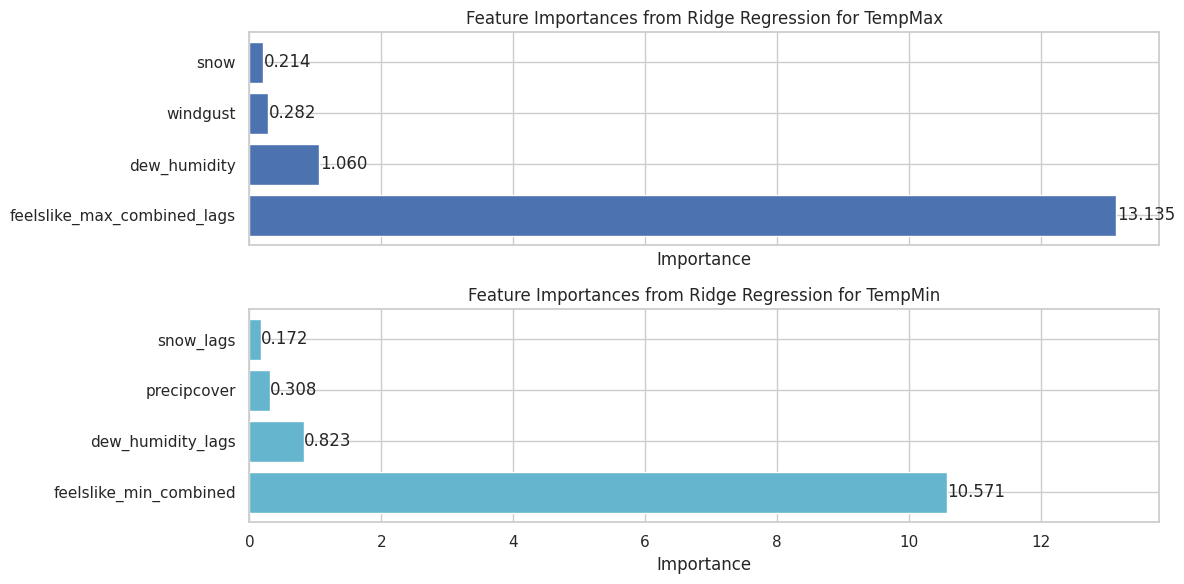

                       Feature  Importance
0  feelslike_max_combined_lags   13.134932
1                 dew_humidity    1.059887
3                     windgust    0.282020
2                         snow    0.213905
                  Feature  Importance
0  feelslike_min_combined   10.570798
1       dew_humidity_lags    0.822620
3             precipcover    0.308456
2               snow_lags    0.171574


In [337]:
# Extract and sort feature importances for TempMax
importances_max = abs(ridge_model_max.coef_)
importance_df_max = pd.DataFrame({
    'Feature': X_train_max.columns,
    'Importance': importances_max
}).sort_values(by='Importance', ascending=False)

# Extract and sort feature importances for TempMin
importances_min = abs(ridge_model_min.coef_)
importance_df_min = pd.DataFrame({
    'Feature': X_train_min.columns,
    'Importance': importances_min
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances for TempMax and TempMin
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

# Plot for TempMax
ax1.barh(importance_df_max['Feature'], importance_df_max['Importance'], color=color_pal[0])
ax1.set_title('Feature Importances from Ridge Regression for TempMax')
ax1.set_xlabel('Importance')
for index, value in enumerate(importance_df_max['Importance']):
    ax1.text(value + 0.01, index, f'{value:.3f}', va='center')

# Plot for TempMin
ax2.barh(importance_df_min['Feature'], importance_df_min['Importance'], color=color_pal[9])
ax2.set_title('Feature Importances from Ridge Regression for TempMin')
ax2.set_xlabel('Importance')
for index, value in enumerate(importance_df_min['Importance']):
    ax2.text(value + 0.01, index, f'{value:.3f}', va='center')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

print(importance_df_max)
print(importance_df_min)

### Cross-Validation Performance
- We evaluate the model's stability and performance using five-fold cross-validation on the training set which is computationally efficient while still providing a robust estimate of model performance.
- The training set has 2726 samples. With 5-fold cross-validation, each fold will have approximately 545 samples (each fold should be large enough to represent the overall dataset well).

In [368]:
# Perform 5-fold cross-validation for TempMax
cv_scores_max = cross_val_score(ridge_model_max, X_train_max_scaled, y_train_max, cv=5, scoring='r2')

# Perform 5-fold cross-validation for TempMin
cv_scores_min = cross_val_score(ridge_model_min, X_train_min_scaled, y_train_min, cv=5, scoring='r2')

# Display cross-validation results
print("\n--- Cross-Validation Results ---")
print(f"TempMax - Mean R²: {cv_scores_max.mean():.4f}, Scores: {cv_scores_max}")
print(f"TempMin - Mean R²: {cv_scores_min.mean():.4f}, Scores: {cv_scores_min}")


--- Cross-Validation Results ---
TempMax - Mean R²: 0.9581, Scores: [0.9633471  0.94551719 0.9648483  0.96338988 0.95358412]
TempMin - Mean R²: 0.9640, Scores: [0.980078   0.92228257 0.9623005  0.98311709 0.97227793]


### Validation Set Evaluation
Next, we make predictions on the validation set and evaluate the model using metrics such as **R²**, **RMSE**, and **Durbin-Watson statistics** to assess the model's fit and detect autocorrelation in the residuals.

- **R²**: Tells us how well our independent variables explain the variance in our dependent variable.
- **RMSE**: Provides an understanding of how accurate our predictions are in terms of their magnitude.
- **Durbin-Watson**: Checks for autocorrelation in our model’s residuals, ensuring that the errors are independent of each 

In [374]:
# Predict on the validation set for TempMax and TempMin
y_pred_val_max = ridge_model_max.predict(X_val_max_scaled)
y_pred_val_min = ridge_model_min.predict(X_val_min_scaled)

# Calculate performance metrics and residuals for TempMax
r2_val_max = r2_score(y_val_max, y_pred_val_max)
rmse_max = np.sqrt(mean_squared_error(y_val_max, y_pred_val_max))
residuals_max = y_val_max - y_pred_val_max
dw_stat_max = durbin_watson(residuals_max)

# Calculate performance metrics and residuals for TempMin
r2_val_min = r2_score(y_val_min, y_pred_val_min)
rmse_min = np.sqrt(mean_squared_error(y_val_min, y_pred_val_min))
residuals_min = y_val_min - y_pred_val_min
dw_stat_min = durbin_watson(residuals_min)

# Display validation results
print("\n--- Validation Set Results ---")
print(f"TempMax - R²: {r2_val_max:.4f}, RMSE: {rmse_max:.4f}, Durbin-Watson: {dw_stat_max:.4f}")
print(f"TempMin - R²: {r2_val_min:.4f}, RMSE: {rmse_min:.4f}, Durbin-Watson: {dw_stat_min:.4f}")



--- Validation Set Results ---
TempMax - R²: 0.9279, RMSE: 2.0044, Durbin-Watson: 1.8047
TempMin - R²: 0.9348, RMSE: 1.4327, Durbin-Watson: 1.3381


#### Brief overview of the ACF and PACF:

- **ACF Plot**: Measures the correlation between a time series and its own past values (lags). It shows how the current value of a series is related to its past values at different time lags.
- **PACF Plot**: Measures the correlation between a time series and its past values, but after removing the effects of the intermediate lags. It shows the direct relationship between the current value and a specific lagged value, without considering the influence of other lags.

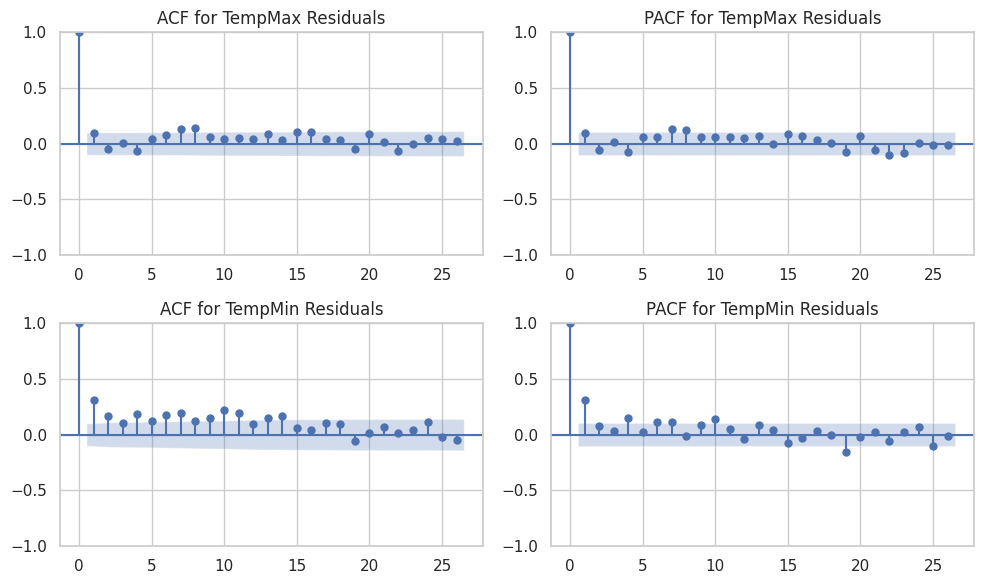

In [375]:
# Plot ACF and PACF of residuals for TempMax and TempMin
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

# ACF for TempMax Residuals
plot_acf(residuals_max, ax=ax[0, 0])
ax[0, 0].set_title('ACF for TempMax Residuals')

# ACF for TempMin Residuals
plot_acf(residuals_min, ax=ax[1, 0])
ax[1, 0].set_title('ACF for TempMin Residuals')

# PACF for TempMax Residuals
plot_pacf(residuals_max, ax=ax[0, 1])
ax[0, 1].set_title('PACF for TempMax Residuals')

# PACF for TempMin Residuals
plot_pacf(residuals_min, ax=ax[1, 1])
ax[1, 1].set_title('PACF for TempMin Residuals')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### Checking for Heteroscedasticity
To diagnose potential issues with residuals and assess how well the model captures data patterns, we perform the following steps:
- **Add a Constant**: Include an intercept term in the feature matrix to ensure the Breusch-Pagan test correctly accounts for it.
- **Breusch-Pagan Test**: Evaluate residuals for heteroscedasticity (non-constant error variance) using the test results.
- **Scatter Plots**: Plot residuals against fitted values to visually inspect for patterns and assess model performance.


--- Breusch-Pagan Test Results ---
TempMax:
LM Statistic: 10.8428
LM Test p-value: 0.0284
F-Statistic: 2.7528
F-Test p-value: 0.0279
TempMin:
LM Statistic: 70.9524
LM Test p-value: 0.0000
F-Statistic: 21.4397
F-Test p-value: 0.0000


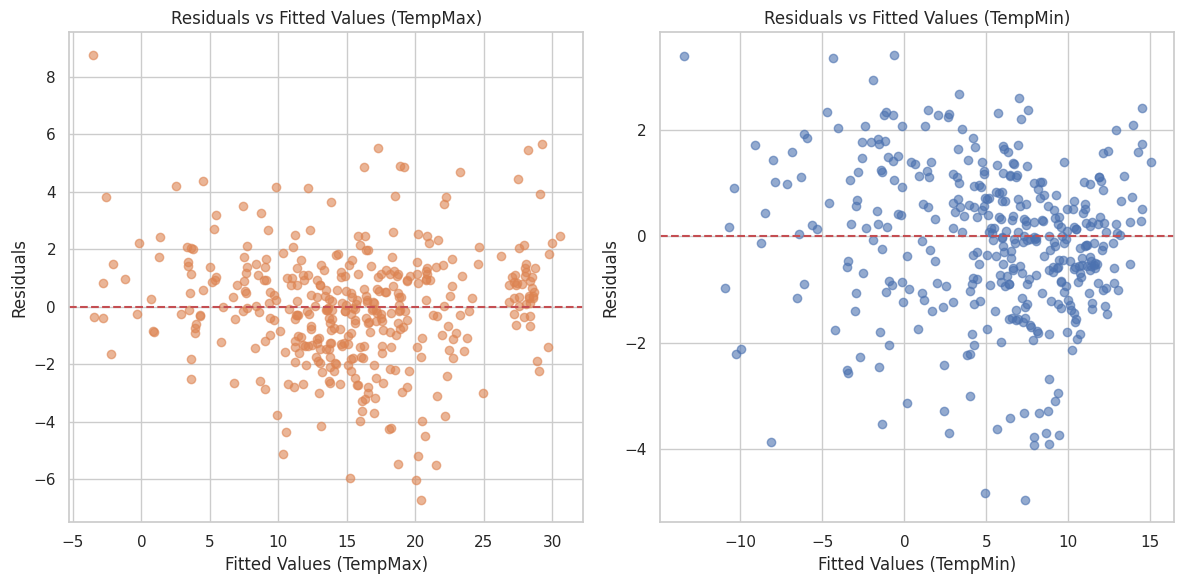

In [297]:
# Add a constant to the validation set features
X_val_max_scaled_with_const = sm.add_constant(X_val_max_scaled)
X_val_min_scaled_with_const = sm.add_constant(X_val_min_scaled)

# Perform the Breusch-Pagan test on the residuals for TempMax and TempMin
bp_test_max = het_breuschpagan(residuals_max, X_val_max_scaled_with_const)
bp_test_min = het_breuschpagan(residuals_min, X_val_min_scaled_with_const)

# Display Breusch-Pagan test results
labels = ['LM Statistic', 'LM Test p-value', 'F-Statistic', 'F-Test p-value']
print("\n--- Breusch-Pagan Test Results ---")
print('TempMax:')
for label, result in zip(labels, bp_test_max):
    print(f'{label}: {result:.4f}')
print('TempMin:')
for label, result in zip(labels, bp_test_min):
    print(f'{label}: {result:.4f}')

# Calculate fitted values for the validation set
fitted_values_max = ridge_model_max.predict(X_val_max_scaled)
fitted_values_min = ridge_model_min.predict(X_val_min_scaled)

# Scatter plots for residuals vs fitted values
plt.figure(figsize=(12, 6))

# Plot for TempMax
plt.subplot(1, 2, 1)
plt.scatter(fitted_values_max, residuals_max, color=color_pal[1], alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values (TempMax)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (TempMax)')
plt.grid(True)

# Plot for TempMin
plt.subplot(1, 2, 2)
plt.scatter(fitted_values_min, residuals_min, color=color_pal[0], alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values (TempMin)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (TempMin)')
plt.grid(True)

plt.tight_layout()
plt.show()


### Additional Performance Metrics
We also calculate the Mean Absolute Error (MAE) and the Adjusted R² to provide further insights into the model's performance.

- **MAE** complements RMSE by offering a metric that’s less affected by outliers and easier to interpret in terms of average prediction error.
- **Adjusted R²** provides a more nuanced view of model performance, accounting for the number of predictors and avoiding overestimation of model fit.

In [298]:
# Calculate MAE for TempMax and TempMin
mae_max = mean_absolute_error(y_val_max, y_pred_val_max)
mae_min = mean_absolute_error(y_val_min, y_pred_val_min)
print(f"TempMax - MAE: {mae_max:.4f}")
print(f"TempMin - MAE: {mae_min:.4f}")

# Calculate Adjusted R² for TempMax and TempMin
n_max, p_max = X_val_max_scaled.shape
n_min, p_min = X_val_min_scaled.shape
adjusted_r2_max = 1 - (1 - r2_val_max) * (n_max - 1) / (n_max - p_max - 1)
adjusted_r2_min = 1 - (1 - r2_val_min) * (n_min - 1) / (n_min - p_min - 1)
print(f"TempMax - Adjusted R²: {adjusted_r2_max:.4f}")
print(f"TempMin - Adjusted R²: {adjusted_r2_min:.4f}")


TempMax - MAE: 1.4911
TempMin - MAE: 1.1073
TempMax - Adjusted R²: 0.9271
TempMin - Adjusted R²: 0.9341


### Visualizing the Results
To better understand the model’s predictions, we visualize the actual vs. predicted values, residuals, and their distribution.

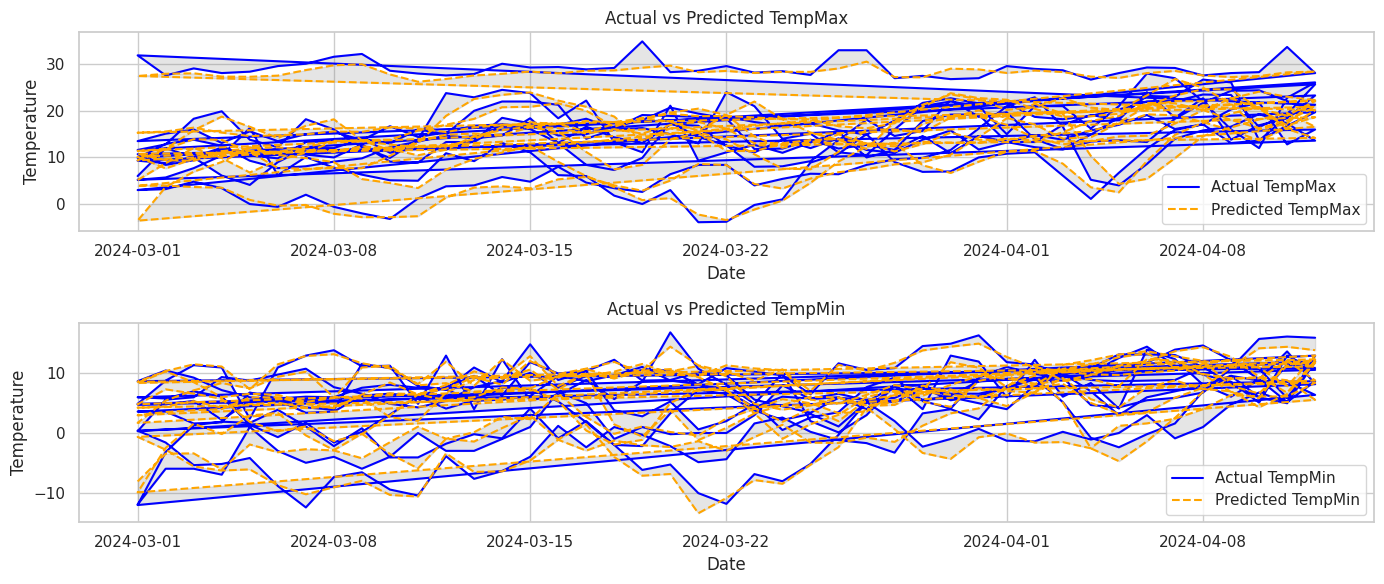

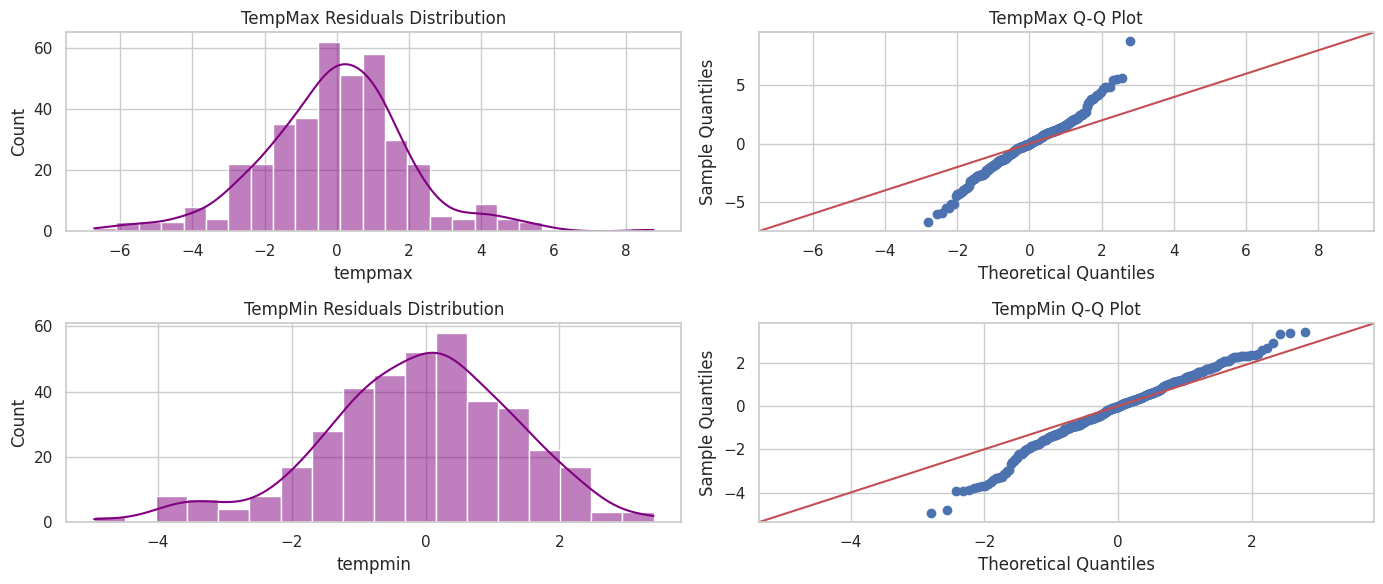

In [299]:
# Plot Actual vs Predicted values for TempMax and TempMin
plt.figure(figsize=(14, 6))

# TempMax
plt.subplot(2, 1, 1)
plt.plot(y_val_max.index, y_val_max, label='Actual TempMax', color='blue')
plt.plot(y_val_max.index, y_pred_val_max, label='Predicted TempMax', color='orange', linestyle='--')
plt.fill_between(y_val_max.index, y_val_max, y_pred_val_max, color='gray', alpha=0.2)
plt.title('Actual vs Predicted TempMax')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

# TempMin
plt.subplot(2, 1, 2)
plt.plot(y_val_min.index, y_val_min, label='Actual TempMin', color='blue')
plt.plot(y_val_min.index, y_pred_val_min, label='Predicted TempMin', color='orange', linestyle='--')
plt.fill_between(y_val_min.index, y_val_min, y_pred_val_min, color='gray', alpha=0.2)
plt.title('Actual vs Predicted TempMin')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Residuals distribution and Q-Q plots
fig, ax = plt.subplots(2, 2, figsize=(14, 6))

# TempMax Residuals
sns.histplot(residuals_max, kde=True, ax=ax[0, 0], color='purple')
ax[0, 0].set_title('TempMax Residuals Distribution')
sm.qqplot(residuals_max, line ='45', ax=ax[0, 1])
ax[0, 1].set_title('TempMax Q-Q Plot')

# TempMin Residuals
sns.histplot(residuals_min, kde=True, ax=ax[1, 0], color='purple')
ax[1, 0].set_title('TempMin Residuals Distribution')
sm.qqplot(residuals_min, line ='45', ax=ax[1, 1])
ax[1, 1].set_title('TempMin Q-Q Plot')

plt.tight_layout()
plt.show()

## Test Set Evaluation

### Predicting on the Test Set

In [320]:
# Predict TempMax and TempMin using the trained Ridge Regression models
y_pred_test_max = ridge_model_max.predict(X_test_max_scaled)
y_pred_test_min = ridge_model_min.predict(X_test_min_scaled)


### Calculating Performance Metrics

In [321]:
# Calculate R², RMSE, and MAE for TempMax
r2_test_max = r2_score(y_test_max, y_pred_test_max)
rmse_test_max = np.sqrt(mean_squared_error(y_test_max, y_pred_test_max))
mae_test_max = mean_absolute_error(y_test_max, y_pred_test_max)

# Calculate R², RMSE, and MAE for TempMin
r2_test_min = r2_score(y_test_min, y_pred_test_min)
rmse_test_min = np.sqrt(mean_squared_error(y_test_min, y_pred_test_min))
mae_test_min = mean_absolute_error(y_test_min, y_pred_test_min)

# Display test set performance results
print("\n--- Test Set Results ---")
print(f"TempMax - R²: {r2_test_max:.4f}, RMSE: {rmse_test_max:.4f}, MAE: {mae_test_max:.4f}")
print(f"TempMin - R²: {r2_test_min:.4f}, RMSE: {rmse_test_min:.4f}, MAE: {mae_test_min:.4f}")



--- Test Set Results ---
TempMax - R²: 0.9125, RMSE: 1.9905, MAE: 1.5322
TempMin - R²: 0.9465, RMSE: 1.2086, MAE: 0.9563


### Residual Analysis

In [322]:
# Calculate residuals for TempMax and TempMin
residuals_test_max = y_test_max - y_pred_test_max
residuals_test_min = y_test_min - y_pred_test_min

# Durbin-Watson statistic for TempMax and TempMin to check for autocorrelation in residuals
dw_stat_test_max = durbin_watson(residuals_test_max)
dw_stat_test_min = durbin_watson(residuals_test_min)

# Display Durbin-Watson statistics
print(f"TempMax - Durbin-Watson: {dw_stat_test_max:.4f}")
print(f"TempMin - Durbin-Watson: {dw_stat_test_min:.4f}")

TempMax - Durbin-Watson: 1.6933
TempMin - Durbin-Watson: 1.3167


### Visualizing Residuals

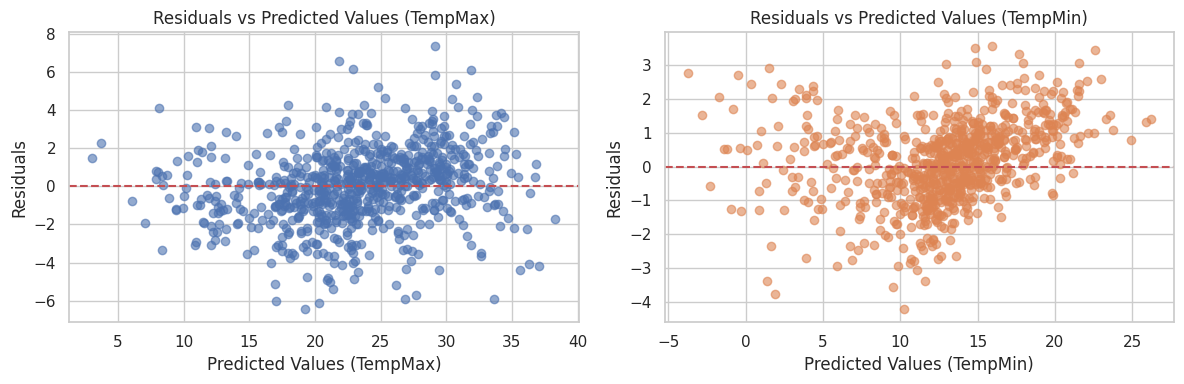

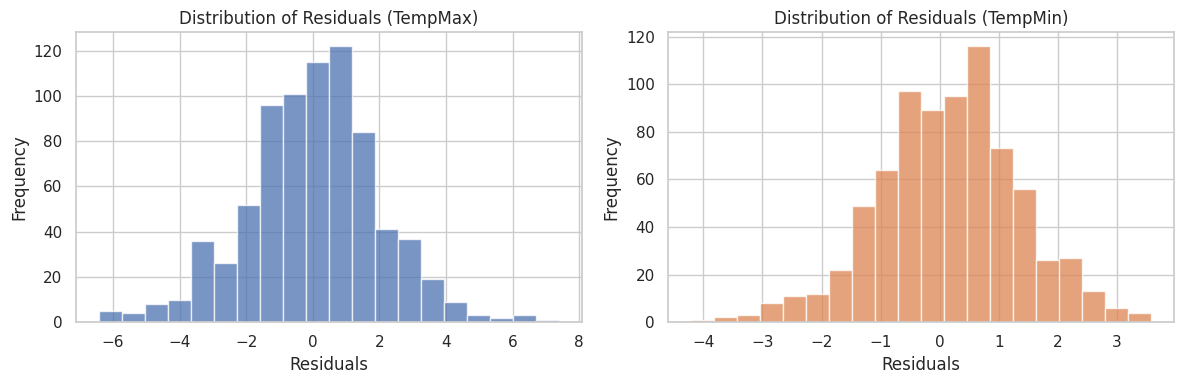

In [324]:
# Plot residuals vs fitted values for TempMax and TempMin
plt.figure(figsize=(12, 4))

# Plot for TempMax
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test_max, residuals_test_max, color=color_pal[0], alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values (TempMax)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (TempMax)')
plt.grid(True)

# Plot for TempMin
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test_min, residuals_test_min, color=color_pal[1], alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values (TempMin)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (TempMin)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot the distribution of residuals (histogram)
plt.figure(figsize=(12, 4))

# Histogram for TempMax Residuals
plt.subplot(1, 2, 1)
plt.hist(residuals_test_max, bins=20, color=color_pal[0], alpha=0.75)
plt.title('Distribution of Residuals (TempMax)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)

# Histogram for TempMin Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals_test_min, bins=20, color=color_pal[1], alpha=0.75)
plt.title('Distribution of Residuals (TempMin)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

### Test Set ACF and PACF Analysis of Residuals

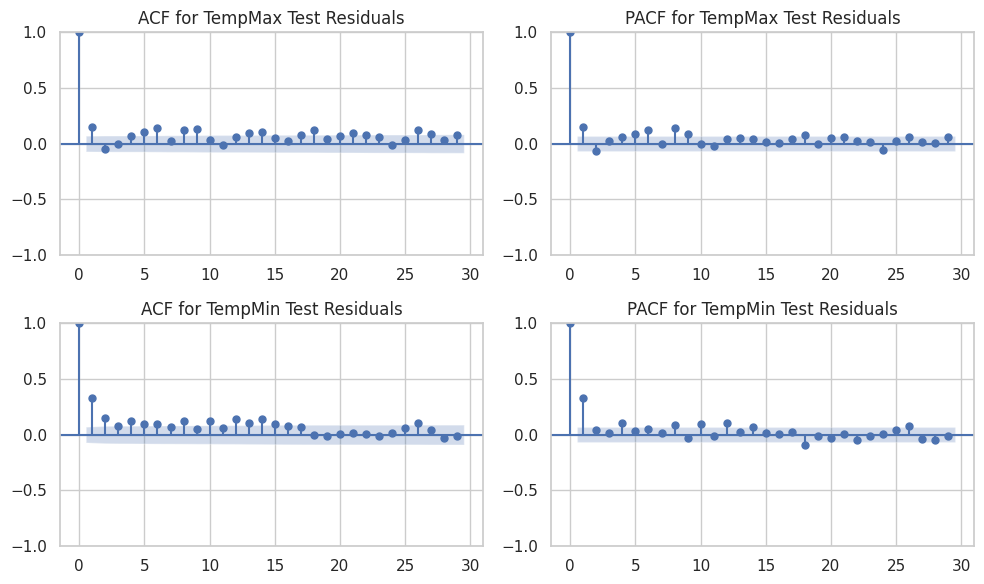

In [325]:
# Plot ACF and PACF of residuals for TempMax and TempMin
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

# ACF for TempMax Residuals
plot_acf(residuals_test_max, ax=ax[0, 0])
ax[0, 0].set_title('ACF for TempMax Test Residuals')

# ACF for TempMin Residuals
plot_acf(residuals_test_min, ax=ax[1, 0])
ax[1, 0].set_title('ACF for TempMin Test Residuals')

# PACF for TempMax Residuals
plot_pacf(residuals_test_max, ax=ax[0, 1])
ax[0, 1].set_title('PACF for TempMax Test Residuals')

# PACF for TempMin Residuals
plot_pacf(residuals_test_min, ax=ax[1, 1])
ax[1, 1].set_title('PACF for TempMin Test Residuals')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


## My Test Set Evaluation

In [300]:
# Optional: Advanced statistical analysis (e.g., confidence intervals)
X_test_max_scaled_with_const = sm.add_constant(X_test_max_scaled)
X_test_min_scaled_with_const = sm.add_constant(X_test_min_scaled)

ols_model_max = sm.OLS(y_train_max, sm.add_constant(X_train_max_scaled)).fit(cov_type='HC3')
ols_model_min = sm.OLS(y_train_min, sm.add_constant(X_train_min_scaled)).fit(cov_type='HC3')

predictions_max = ols_model_max.get_prediction(X_test_max_scaled_with_const)
predictions_min = ols_model_min.get_prediction(X_test_min_scaled_with_const)

summary_max = predictions_max.summary_frame(alpha=0.05)
summary_min = predictions_min.summary_frame(alpha=0.05)

confidence_intervals_max = summary_max[['obs_ci_lower', 'obs_ci_upper']]
confidence_intervals_min = summary_min[['obs_ci_lower', 'obs_ci_upper']]

print("\n--- Confidence Intervals for TempMax Predictions ---")
print(confidence_intervals_max.head())

print("\n--- Confidence Intervals for TempMin Predictions ---")
print(confidence_intervals_min.head())


TempMax - Test R²: 0.9125076327616144 Test RMSE: 1.9904610856292024 Test MAE: 1.5322378030414003
TempMin - Test R²: 0.9465359579133543 Test RMSE: 1.2086469406631597 Test MAE: 0.9562681620629433

--- Confidence Intervals for TempMax Predictions ---
   obs_ci_lower  obs_ci_upper
0     21.529994     29.297765
1     19.132382     26.900258
2     20.291789     28.075985
3     23.635360     31.431550
4     22.579804     30.352799

--- Confidence Intervals for TempMin Predictions ---
   obs_ci_lower  obs_ci_upper
0     10.841775     16.248597
1     10.295483     15.701684
2     10.773007     16.177837
3      6.936678     12.355180
4      6.342142     11.759272


In [301]:
# Fit OLS models with robust standard errors
ols_model_max = sm.OLS(y_train_max, sm.add_constant(X_train_max_scaled)).fit(cov_type='HC3')
ols_model_min = sm.OLS(y_train_min, sm.add_constant(X_train_min_scaled)).fit(cov_type='HC3')

# Summary of OLS models
print("\n--- OLS Model Summary for TempMax ---")
print(ols_model_max.summary())

print("\n--- OLS Model Summary for TempMin ---")
print(ols_model_min.summary())



--- OLS Model Summary for TempMax ---
                            OLS Regression Results                            
Dep. Variable:                tempmax   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 1.239e+04
Date:                Wed, 21 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:49:28   Log-Likelihood:                -5729.1
No. Observations:                2726   AIC:                         1.147e+04
Df Residuals:                    2721   BIC:                         1.150e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        

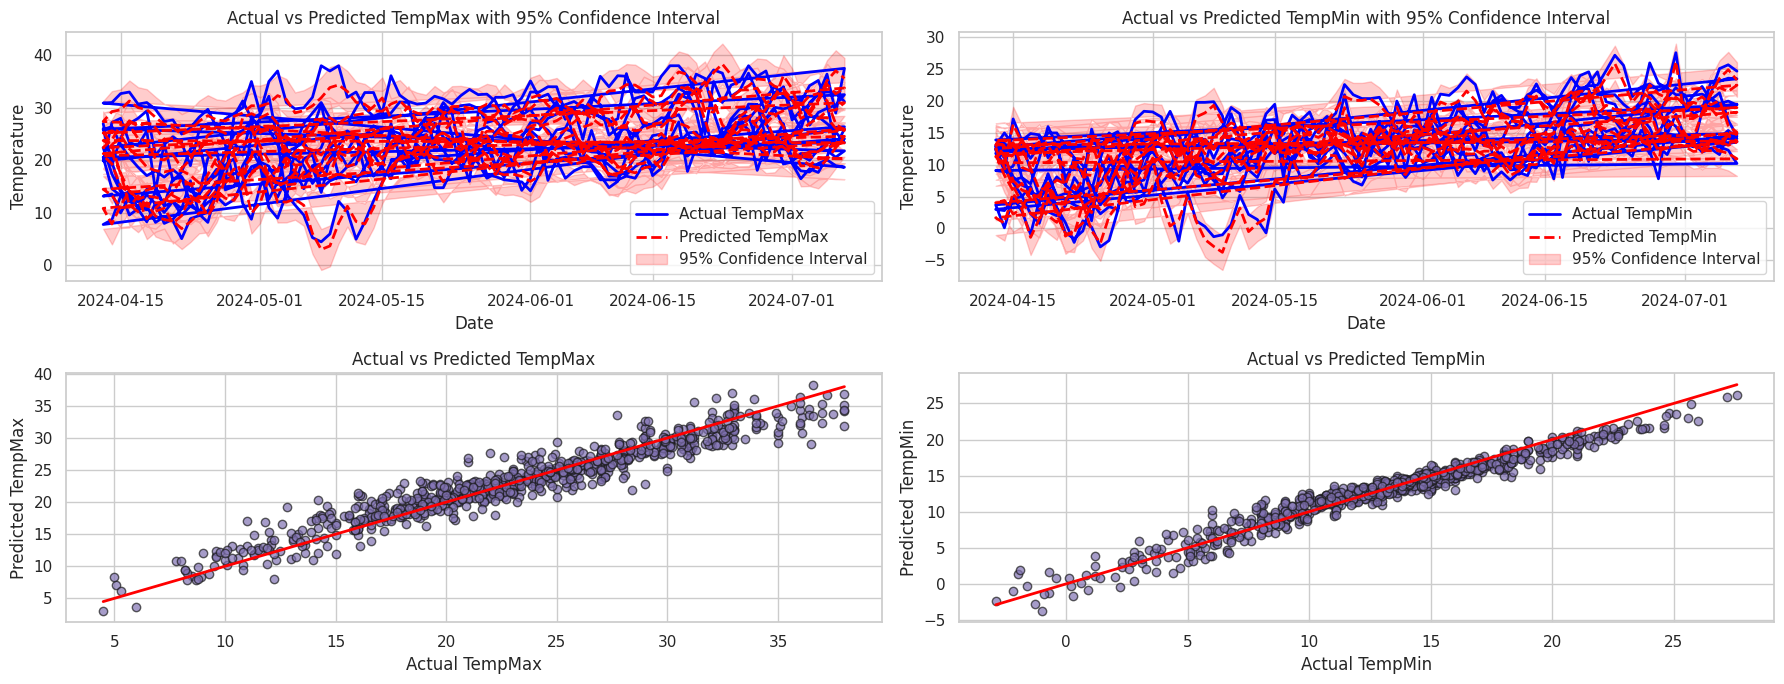

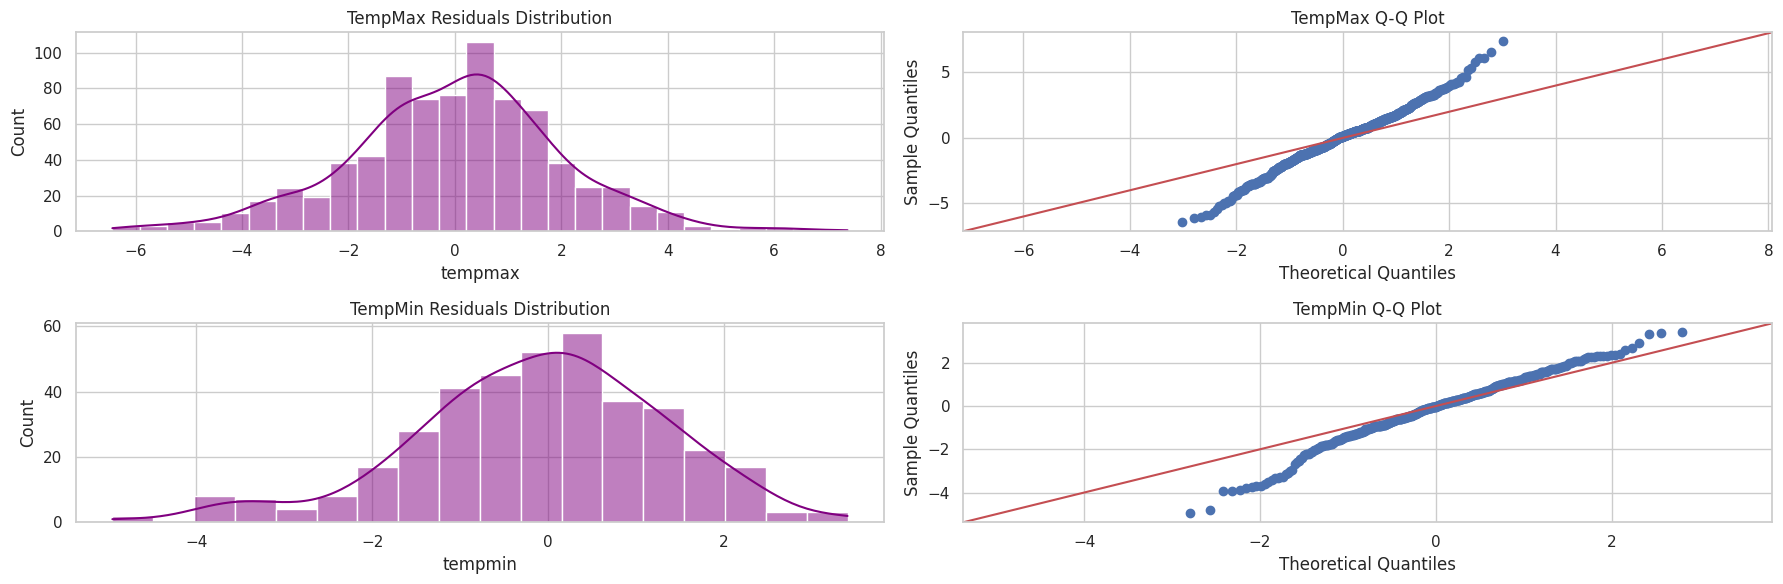

In [332]:
residuals_max = y_test_max - y_pred_test_max
residuals_max = y_test_max - y_pred_test_max

# Define the figure and axes for subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 7))  # Adjust figsize for better spacing

# Plot TempMax predictions with confidence intervals
axs[0, 0].plot(y_test_max.index, y_test_max, label='Actual TempMax', color='blue', linewidth=2)
axs[0, 0].plot(y_test_max.index, y_pred_test_max, label='Predicted TempMax', color='red', linestyle='--', linewidth=2)
axs[0, 0].fill_between(y_test_max.index, confidence_intervals_max['obs_ci_lower'], confidence_intervals_max['obs_ci_upper'], color='red', alpha=0.2, label='95% Confidence Interval')
axs[0, 0].set_title('Actual vs Predicted TempMax with 95% Confidence Interval')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Temperature')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot TempMin predictions with confidence intervals
axs[0, 1].plot(y_test_min.index, y_test_min, label='Actual TempMin', color='blue', linewidth=2)
axs[0, 1].plot(y_test_min.index, y_pred_test_min, label='Predicted TempMin', color='red', linestyle='--', linewidth=2)
axs[0, 1].fill_between(y_test_min.index, confidence_intervals_min['obs_ci_lower'], confidence_intervals_min['obs_ci_upper'], color='red', alpha=0.2, label='95% Confidence Interval')
axs[0, 1].set_title('Actual vs Predicted TempMin with 95% Confidence Interval')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Temperature')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Scatter plot for TempMax
axs[1, 0].scatter(y_test_max, y_pred_test_max, color=color_pal[4], edgecolor='k', alpha=0.7)
axs[1, 0].plot([y_test_max.min(), y_test_max.max()], [y_test_max.min(), y_test_max.max()], color='red', lw=2)
axs[1, 0].set_title('Actual vs Predicted TempMax')
axs[1, 0].set_xlabel('Actual TempMax')
axs[1, 0].set_ylabel('Predicted TempMax')

# Scatter plot for TempMin
axs[1, 1].scatter(y_test_min, y_pred_test_min, color=color_pal[4], edgecolor='k', alpha=0.7)
axs[1, 1].plot([y_test_min.min(), y_test_min.max()], [y_test_min.min(), y_test_min.max()], color='red', lw=2)
axs[1, 1].set_title('Actual vs Predicted TempMin')
axs[1, 1].set_xlabel('Actual TempMin')
axs[1, 1].set_ylabel('Predicted TempMin')

# Adjust layout
plt.tight_layout()
plt.show()

# Plot Residuals distribution and Q-Q plots
fig, ax = plt.subplots(2, 2, figsize=(18, 6))

# TempMax Residuals
sns.histplot(residuals_max, kde=True, ax=ax[0, 0], color='purple')
ax[0, 0].set_title('TempMax Residuals Distribution')
sm.qqplot(residuals_max, line ='45', ax=ax[0, 1])
ax[0, 1].set_title('TempMax Q-Q Plot')

# TempMin Residuals
sns.histplot(residuals_min, kde=True, ax=ax[1, 0], color='purple')
ax[1, 0].set_title('TempMin Residuals Distribution')
sm.qqplot(residuals_min, line ='45', ax=ax[1, 1])
ax[1, 1].set_title('TempMin Q-Q Plot')

plt.tight_layout()
plt.show()


In [318]:
predicted_df = test.copy()
predicted_df['predicted_max'] = y_pred_test_max
predicted_df['predicted_min'] = y_pred_test_min

In [319]:
predicted_df[['tempmax', 'predicted_max', 'tempmin', 'predicted_min']]

,tempmax,predicted_max,tempmin,predicted_min
datetime,,,,
2024-04-13,27.0,25.413834,13.0,13.504959
2024-04-14,19.1,23.016299,15.0,12.964787
2024-04-15,24.3,24.183815,13.1,13.450338
2024-04-16,27.0,27.533346,8.0,9.598367
2024-04-17,28.0,26.466229,7.0,9.009679
...,...,...,...,...
2024-07-03,30.6,29.449428,18.9,18.120506
2024-07-04,32.8,31.625805,21.2,20.977992
2024-07-05,33.0,35.166629,25.1,23.578012


# Summary and Next Steps:
- Further feature engineering and testing.
- Address heteroskedasticity and autocorrelation.
- Test other models' performance such as ARIMA